In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataSet = 'iono'
filePath = '/content/drive/MyDrive/October 2022/thesis/Final_MH/iono_GA/'+dataSet+'.csv' 
data = pd.read_csv(filePath)
data = data.drop(['Unnamed: 0'], axis=1)
data

# New Section

In [ ]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
from itertools import permutations

In [ ]:
import seaborn as sns

In [ ]:
from keras.datasets import mnist
from sklearn.manifold import TSNE

In [ ]:
from sklearn.svm import SVC

In [ ]:
y = data['Column_35']
X = data
X = X.drop(['Column_35'], axis=1)
X

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_train

In [ ]:
x_train = x_train[:, 1:]
x_test = x_test[:, 1:]
y_train = y_train[:, 1:]
y_test = y_test[:, 1:]

In [ ]:
print(x_train.shape)
print(y_train.shape)
x_train

In [ ]:
print(x_test.shape)
print(y_test.shape)

In [ ]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [ ]:
x_train_flat = x_train
x_test_flat = x_test
x_train_flat.shape

(280, 34)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create a t-SNE object
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot the data
print("Samples from Training Data")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='cool')
plt.colorbar()
plt.show()


x_tsne = tsne.fit_transform(x_test_flat)
# Plot the data
print("Samples from Validation Data")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='cool')
plt.colorbar()
plt.show()

In [ ]:
Classifier_input = Input((34,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
le = LabelBinarizer()

In [ ]:
y_train_onehot = le.fit_transform(y_train)
y_test_onehot = le.transform(y_test)
y_train_onehot.shape
y_test_onehot.shape
y_train_onehot

# **OneHot**

In [ ]:
y_train_onehot = []
for i in y_train:
  if i==0:
    y_train_onehot.append([1,0])
  else:
    y_train_onehot.append([0,1])

y_train_onehot = pd.DataFrame(y_train_onehot)
y_train_onehot.shape

y_test_onehot = []
for i in y_test:
  if i==0:
    y_test_onehot.append([1,0])
  else:
    y_test_onehot.append([0,1])
y_test_onehot = pd.DataFrame(y_test_onehot)
y_test_onehot.shape

(70, 2)

In [ ]:
y_tr= []
for i in y_train:
  y_tr.append(i)

y_tr = pd.DataFrame(y_tr)
y_tr.shape

y_te = []
for i in y_test:
  y_te.append(i)
y_te = pd.DataFrame(y_te)
y_te.shape

y_train = y_tr
y_train

y_test = y_te
y_test


In [ ]:
Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
Classifier_model.fit(x_train_flat,y_train_onehot, validation_data=(x_test_flat,y_test_onehot),epochs=500)

In [ ]:
X_train = np.load('/content/drive/MyDrive/October 2022/thesis/Final_MH/iono_GA/train.npy')
X_test = np.load('/content/drive/MyDrive/October 2022/thesis/Final_MH/iono_GA/train.npy')

X_train.shape
X_test.shape

(280, 3, 34)


# **Triplet NN**

In [ ]:
def triplet_loss(y_true, y_pred, alpha = 0.4): 
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [ ]:
# print(x_train[0].shape)

In [ ]:
def create_base_network(in_dims):
    in_dim = in_dims

    model = Sequential()
    model.add(Dense(10, input_dim=in_dims, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(in_dim, activation='relu'))

    # model.add(Dense(600))
    
    return model

In [ ]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [ ]:
anchor_input = Input((x_train[0].shape), name='anchor_input')
positive_input = Input((x_train[0].shape), name='positive_input')
negative_input = Input((x_train[0].shape), name='negative_input')

Shared_DNN = create_base_network(34)


encoded_anchor = Shared_DNN(anchor_input)
encoded_positive = Shared_DNN(positive_input)
encoded_negative = Shared_DNN(negative_input)


merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim)

In [ ]:
model.summary()

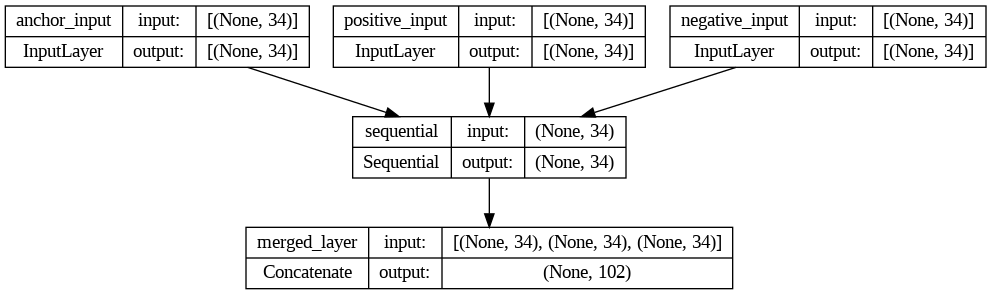

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "my_first_model.png", show_shapes = True)

In [ ]:
trained_model = Model(inputs=anchor_input, outputs=encoded_anchor)

In [ ]:
Anchor = X_train[:,0,:].reshape(-1,34,1)
Positive = X_train[:,1,:].reshape(-1,34,1)
Negative = X_train[:,2,:].reshape(-1,34,1)
Anchor_test = X_test[:,0,:].reshape(-1,34,1)
Positive_test = X_test[:,1,:].reshape(-1,34,1)
Negative_test = X_test[:,2,:].reshape(-1,34,1)

Y_dummy = np.empty((Anchor.shape[0],300))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2), batch_size=512, epochs=500) #epochs=500)
model.save_weights('/content/drive/MyDrive/October 2022/thesis/Final_MH/iono_GA/triplet_weights_iono.hdf5')


In [ ]:
trained_model.load_weights('/content/drive/MyDrive/October 2022/thesis/Final_MH/iono_GA/triplet_weights_iono.hdf5')

In [ ]:
x_train.shape
y_train.shape

(280, 1)

In [ ]:
tsne = TSNE(n_components=2)
#tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, verbose=1)
X_train_trm = trained_model.predict(x_train[:280].reshape(-1,34,1))
X_test_trm = trained_model.predict(x_test[:70].reshape(-1,34,1))
# X_train_ = np.reshape(X_train_trm, (512,36,1))
# X_test_ = np.reshape(X_test_trm, (512,36,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create a t-SNE object
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
x_tsne = tsne.fit_transform(train_tsne_embeds[:280])
# Plot the data
print("Training data")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train[:280], cmap='cool')
plt.colorbar()
plt.show()


# Fit and transform the data
x_tsne = tsne.fit_transform(eval_tsne_embeds[:70])
# Plot the data
print("Validation data")
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test[:70], cmap='cool')
plt.colorbar()
plt.show()

# **Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc,make_scorer

# **RF**

In [ ]:
clf = RandomForestClassifier(n_estimators=50,random_state=0)
kf = RepeatedStratifiedKFold(n_splits=5)

In [ ]:
print(X_train_trm.shape)
print(y_train.shape)

(280, 34)
(280, 1)


In [ ]:
def custom_auc(ground_truth, predictions):
 fpr, tpr, _ = roc_curve(ground_truth, predictions)    
 return auc(fpr, tpr)

In [ ]:
from sklearn.metrics import make_scorer
my_auc = make_scorer(custom_auc, greater_is_better=True)

In [ ]:
ennlf = cross_val_score(clf, X_test_trm, y_test, cv = kf, scoring='f1')
ennlr = cross_val_score(clf, X_test_trm, y_test, cv = kf, scoring='recall')
ennlp = cross_val_score(clf, X_test_trm, y_test, cv = kf, scoring='precision')

In [ ]:
ennla = cross_val_score(clf, X_test_trm, y_test, cv = kf, scoring=my_auc)

In [ ]:
print(ennlf)
print(ennlr)
print(ennlp)
print(ennla)
print("F1-Score")
print(np.mean(ennlf))
print("Recall")
print(np.mean(ennlr))
print("Precision")
print(np.mean(ennlp))
print("AUC Score")
print(np.mean(ennla))

# **GradBoost**

In [ ]:
clfg = GradientBoostingClassifier(random_state=0)

In [ ]:
ennlgf = cross_val_score(clfg, X_test_trm, y_test, cv = kf, scoring='f1')
ennlgr = cross_val_score(clfg, X_test_trm, y_test, cv = kf, scoring='recall')
ennlgp = cross_val_score(clfg, X_test_trm, y_test, cv = kf, scoring='precision')

In [ ]:
ennlga = cross_val_score(clfg, X_test_trm, y_test, cv = kf, scoring=my_auc)

In [ ]:
print(ennlgf)
print(ennlgr)
print(ennlgp)
print(ennlga)
print("F1-Score")
print(np.mean(ennlgf))
print("Recall")
print(np.mean(ennlgr))
print("Precision")
print(np.mean(ennlgp))
print("AUC Score")
print(np.mean(ennlga))

# **SGD**

In [ ]:
clfs = SGDClassifier(max_iter=1000, tol=1e-4)

In [ ]:
ennlsf = cross_val_score(clfs, X_test_trm, y_test, cv = kf, scoring='f1')
ennlsr = cross_val_score(clfs, X_test_trm, y_test, cv = kf, scoring='recall')
ennlsp = cross_val_score(clfs, X_test_trm, y_test, cv = kf, scoring='precision')

In [ ]:
ennlsa = cross_val_score(clfs, X_test_trm, y_test, cv = kf, scoring=my_auc)

In [ ]:
print(ennlsf)
print(ennlsr)
print(ennlsp)
print(ennlsa)
print("F1-Score")
print(np.mean(ennlsf))
print("Recall")
print(np.mean(ennlsr))
print("Precision")
print(np.mean(ennlsp))
print("AUC Score")
print(np.mean(ennlsa))

# **AdaBoost**

In [ ]:
clfa = AdaBoostClassifier(random_state=0)

In [ ]:
ennlaf = cross_val_score(clfa, X_test_trm, y_test, cv = kf, scoring='f1')
ennlar = cross_val_score(clfa, X_test_trm, y_test, cv = kf, scoring='recall')
ennlap = cross_val_score(clfa, X_test_trm, y_test, cv = kf, scoring='precision')

In [ ]:
ennlaa = cross_val_score(clfa, X_test_trm, y_test, cv = kf, scoring=my_auc)